In [2]:
import sys
sys.path[0] = "/pubhome/qcxia02/work/espalomac"
import espaloma as esp
import math
import torch
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path, PosixPath
import argparse
from ase.units import kcal, mol, Hartree
device = torch.device("cpu")
kcalmol_per_Hartree =  Hartree / (kcal/mol)

In [2]:
print(esp.__file__)

/pubhome/qcxia02/work/espalomac/espaloma/__init__.py


In [3]:
def define_model():
    representation = esp.nn.Sequential( # GNN
        layer=esp.nn.layers.dgl_legacy.gn("SAGEConv"), # use SAGEConv implementation in DGL
        config=[128, "relu", 128, "relu", 128, "relu"], # 3 layers, 128 units, ReLU activation
    )
    readout = esp.nn.readout.janossy.JanossyPooling( # Pooling -> parameters
        in_features=128, config=[128, "relu", 128, "relu", 128, "relu"],
        out_features={              # define modular MM parameters Espaloma will assign
            4: {"k": 6}, # torsion barrier heights (can be positive or negative)
        },
    )
    espaloma_model = torch.nn.Sequential(
                    representation, readout,
                    esp.mm.geometry.GeometryInGraph(), # get torsion angle info
                    esp.mm.energy.EnergyInGraph(terms=["n4"]), # calculate energy
    )
    
    if torch.cuda.is_available():
        espaloma_model = espaloma_model.cuda()

    return espaloma_model

espaloma_model = define_model()

In [4]:
# dataset_name = "/pubhome/qcxia02/work/espalomac/examples/datasets/gen2/OpenFFGen2OptSet1Rochec1cc1(co)o"
dataset_name = "/pubhome/qcxia02/work/espalomac/examples/models/single_E100_TorNet500_mm_subset/train_dataset.pkl"
ds = esp.data.dataset.GraphDataset.load(dataset_name)
print(len(ds))


88


### Train

In [ ]:
modelpath = "./models"
device = torch.device("cpu")
optimizer = torch.optim.Adam(espaloma_model.parameters(), 1e-3)

loss_fn = esp.metrics.GraphMetric(
    # base_metric=torch.nn.MSELoss(), # use mean-squared error loss
    base_metric=esp.metrics.center(torch.nn.MSELoss()), # use centered mean-squared error loss
    between=['u', "u_ref"],         # between predicted and QM energies
    level="g", # compare on graph level
)

for idx_epoch in tqdm(range(1000)):
    for g in ds:
        optimizer.zero_grad()
        g.heterograph = g.heterograph.to(device)
        g = espaloma_model(g.heterograph)
        loss = loss_fn(g)
        loss.backward()
        optimizer.step()
    torch.save(espaloma_model.state_dict(), modelpath + "/%s.th" % idx_epoch)

### Predict

In [5]:
model_dict = espaloma_model.state_dict()
state_dict = {k:v for k,v in model_dict.items() if k in model_dict.keys()}
print(state_dict.keys())

dict_keys(['0.f_in.0.weight', '0.f_in.0.bias', '0._sequential.d0.gn.bias', '0._sequential.d0.gn.fc_self.weight', '0._sequential.d0.gn.fc_neigh.weight', '0._sequential.d2.gn.bias', '0._sequential.d2.gn.fc_self.weight', '0._sequential.d2.gn.fc_neigh.weight', '0._sequential.d4.gn.bias', '0._sequential.d4.gn.fc_self.weight', '0._sequential.d4.gn.fc_neigh.weight', '1.sequential_4.d0.weight', '1.sequential_4.d0.bias', '1.sequential_4.d2.weight', '1.sequential_4.d2.bias', '1.sequential_4.d4.weight', '1.sequential_4.d4.bias', '1.f_out_4_to_k.weight', '1.f_out_4_to_k.bias'])


In [12]:
from ase.units import kcal, mol
inspect_metric = esp.metrics.center(torch.nn.L1Loss(), dim=0) # use mean-squared error loss

subds = ds[3]
modelpath = "/pubhome/qcxia02/work/espalomac/examples/models/single_E100_TorNet500_mm_subset"
ds0Es = []
losss = []
with torch.no_grad():
    # for i in range(10):
    u, u_ref = [], []
    espaloma_model.load_state_dict(torch.load(f"{modelpath}/best2.pt", map_location=torch.device("cpu")))
    espaloma_model(subds.heterograph)
    ds0Es.append(subds.heterograph.nodes["g"].data["u"][:,0][0].to(torch.device("cpu"))*627.5)

    u.append(subds.heterograph.nodes['g'].data['u'][0])
    u_ref.append(subds.heterograph.nodes['g'].data['u_ref'][0])
    u = torch.cat(u, dim=0)
    u_ref = torch.cat(u_ref, dim=0)
    losss.append(inspect_metric(u, u_ref).to(torch.device("cpu")))

    # print(list(range(1,7))*subds.heterograph.nodes["n4"].data["x"][:,:,None])
    print(subds.heterograph.nodes["n4"].data["x"].shape)
    print(subds.heterograph.nodes["n4"].data["k"].shape)
    print(subds.heterograph.nodes["n4"].data["idxs"].shape)
    # print(subds.heterograph.nodes["n4"].data["x"][0:3,:])
    # print(subds.heterograph.nodes["n4"].data["k"][0:3,:])
    # print(subds.heterograph.nodes["g"].data["u"][:,0:3])
    print(subds.heterograph.nodes["g"].data["u_charmm_totE_nodihe"][:,0:3])
    print(subds.heterograph.nodes["g"].data["u_charmm_totE"][:,0:3])
    print(subds.heterograph.nodes["g"].data["u"][:,0:3])
    print(subds.heterograph.nodes["g"].data["u_ref"][:,0:3])
    # print(subds.heterograph.nodes["g"].data["u_charmm_Edihe"][0:3])
    # print(subds.heterograph.nodes["g"].data["u"][:,0:3])
    # print(subds.heterograph.nodes["g"].data["u_ref"][:,0:3])
    # plt.plot(np.array(subds.heterograph.nodes["g"].data["u"][0]))
    # plt.plot(np.array(subds.heterograph.nodes["g"].data["u_ref"][0]))


    # break


# print(subds.heterograph.nodes["g"].data["u"][:,0:3])
# print(subds.heterograph.nodes["g"].data["u_ref"][:,0:3])
# print(subds.heterograph.nodes["g"].data['u_qm'][:,0:3])
# print(subds.heterograph.nodes["g"].data["u_gaff-1.81"][:,0:3])
# print(subds.heterograph.nodes["g"].data['u_openff-1.2.0'][:,0:3])
# print(ds[5].heterograph.nodes["g"].data["u_gaff-1.81"])
# print(ds[5].heterograph.nodes["g"].data['u_openff-1.2.0'])

# from matplotlib import pyplot as plt
# plt.xlabel("epoch")
# plt.ylabel("kcal/mol")
# plt.plot(ds0Es)


# from matplotlib import pyplot as plt
# plt.xlabel("epoch")
# import numpy as np
# # losss = np.array(losss) * 627.5 # Ha -> kcal/mol`   `
# # plt.ylabel("loss(kcal/mol)")
# losss = np.array(losss)
# plt.ylabel("loss(Hartree)")

# plt.plot(losss)

torch.Size([76, 24])
torch.Size([76, 6])
torch.Size([76, 4])
tensor([[13.2946, 11.5269, 12.8413]])
tensor([[18.9971, 21.1839, 17.6691]])
tensor([[20.0852, 20.2423, 20.7547]])
tensor([[1.3645, 6.0740, 2.8729]])


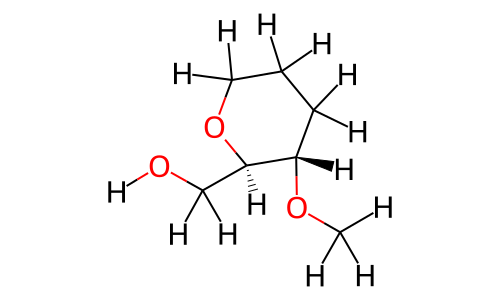

In [15]:
display(subds.mol)

In [4]:
from pathlib import Path
from ase.units import Hartree, kcal, mol
modelpath = Path("/pubhome/qcxia02/work/espalomac/examples/models/single_E10000")
testset = modelpath / "test_dataset.pkl"
ds_test = esp.data.dataset.GraphDataset.load(str(testset))

In [14]:
representation = esp.nn.Sequential( # GNN
    layer=esp.nn.layers.dgl_legacy.gn("SAGEConv"), # use SAGEConv implementation in DGL
    config=[128, "relu", 128, "relu", 128, "relu"], # 3 layers, 128 units, ReLU activation
)
readout = esp.nn.readout.janossy.JanossyPooling( # Pooling -> parameters
    in_features=128, config=[128, "relu", 128, "relu", 128, "relu"],
    out_features={              # define modular MM parameters Espaloma will assign
        4: {"k": 6}, # torsion barrier heights (can be positive or negative)
    },
)

espaloma_model = torch.nn.Sequential(
                representation, readout,
                esp.mm.geometry.GeometryInGraph(), # get torsion angle info
                esp.mm.energy.EnergyInGraph(terms=["n4"]), # calculate energy
)

In [17]:
kcalmol_per_Hartree =  Hartree / (kcal/mol)
device = torch.device("cpu")
import numpy as np

inspect_metric = esp.metrics.center(torch.nn.L1Loss(), dim=0) # use mean-squared error loss
with torch.no_grad():
    # for idx_epoch in tqdm(range(N)):
    espaloma_model.load_state_dict(
        # torch.load("%s.th" % idx_epoch)
        # torch.load(str(modelpath / ("%s.th" % idx_epoch)), map_location=device)
        torch.load(str(modelpath / "best.pt"))
    )

    u = []
    u_ref = []
    losss = []
    # for g in tqdm(ds_test):
    for g in tqdm([ds_test[212]]):
        g.heterograph = g.heterograph.to(device)
        espaloma_model(g.heterograph)
        # u.append(g.nodes['g'].data['u'])
        # u.append(g.nodes['g'].data['u'][0])
        # u_ref.append(g.nodes['g'].data['u_ref'][0])
        print(g.nodes['g'].data['u_charmm_totE'])
        print(g.nodes['g'].data['u_charmm_totE_nodihe'])
        u = g.nodes['g'].data['u'][0]
        print(u)
        u_ref = g.nodes['g'].data['u_ref'][0]
        print(u_ref)
        u = torch.cat([u], dim=0)
        # print(u)
        u_ref = torch.cat([u_ref], dim=0)
        # print(u_ref)
        # losss.append(inspect_metric(u, u_ref).to(device)) * kcalmol_per_Hartree
        losss.append(inspect_metric(u, u_ref).to(device) * kcalmol_per_Hartree)




100%|██████████| 1/1 [00:00<00:00, 15.19it/s]

tensor([[97.3226, 93.8893, 93.2817, 90.9321, 90.6747, 89.8850, 89.7408, 89.6328,
         89.9489, 90.2641, 91.1135, 92.8594, 95.3047, 98.9111, 98.9015, 99.0872,
         97.7134, 99.0059, 98.8398, 98.6841, 98.8336, 98.9463, 98.9707, 98.7913,
         98.4027, 98.3239, 98.2765, 98.2290, 98.2092, 98.1538, 98.1308, 98.1423,
         98.2335, 98.4164, 98.5504, 98.5253, 98.4387, 98.3585, 98.2473, 98.1780,
         98.1909, 98.2224, 98.2492, 98.2461]])
tensor([[73.2225, 69.4885, 68.5084, 66.0056, 65.5958, 64.7689, 64.4647, 64.1673,
         64.2415, 64.2335, 64.7915, 66.7402, 70.1955, 75.3015, 75.3402, 75.9492,
         73.9894, 75.8391, 75.6468, 75.4728, 75.7134, 75.8780, 75.9942, 75.8557,
         75.4489, 75.4006, 75.3588, 75.3152, 75.3020, 75.2542, 75.2419, 75.2627,
         75.3517, 75.5113, 75.6114, 75.5693, 75.4706, 75.3872, 75.2814, 75.2323,
         75.2619, 75.2989, 75.3298, 75.3269]])
tensor([1.3491, 1.3430, 1.3414, 1.3376, 1.3367, 1.3353, 1.3342, 1.3328, 1.3318,
        1.3304, 

In [11]:
print(losss)


[tensor(14.0099)]


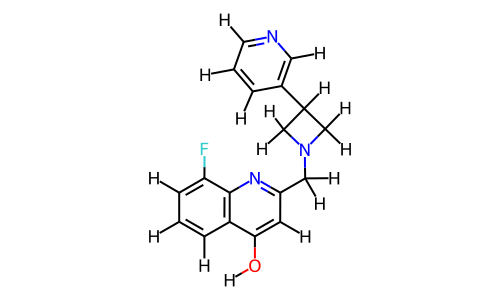

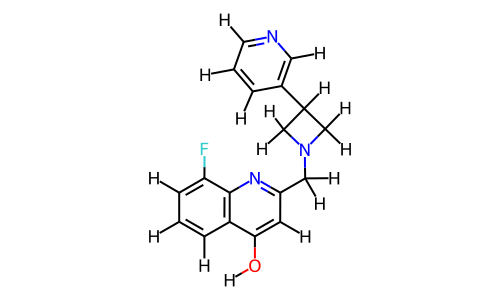

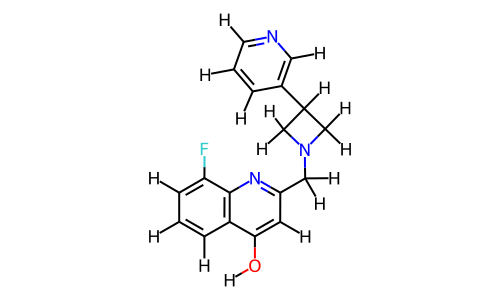

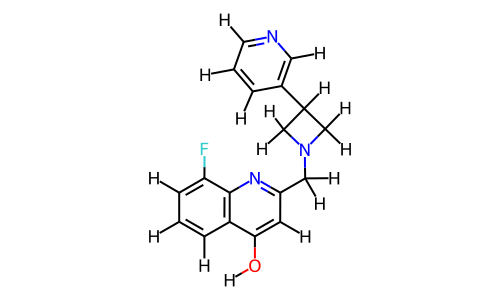

In [13]:
display(ds_test[212].mol)
display(ds_test[212].mol)
display(ds_test[212].mol)
display(ds_test[212].mol)
